# Titanic Survival Classification – Data Preparation

## 1. Setup and Data Load
## 2. Initial Exploration
## 3. Preprocessing
## 4. Feature and Target Selection
## 5. Save Cleaned Data (Optional)

In [1]:
import pandas as pd

# Load Titanic dataset
file_path = 'data/titanic.csv'  # adjust if needed
titanic_data = pd.read_csv(file_path)

In [2]:
# View basic dataset shape
print("Shape:", titanic_data.shape)

# Preview column names
print("\nColumns:")
print(titanic_data.columns.tolist())

# Show first few rows
print("\nTop rows:")
print(titanic_data.head())

# Summary statistics
print("\nSummary statistics:")
print(titanic_data.describe(include='all'))

# Check for missing values
print("\nMissing values per column:")
print(titanic_data.isnull().sum())

Shape: (891, 12)

Columns:
['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp', 'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked']

Top rows:
   PassengerId  Survived  Pclass  \
0            1         0       3   
1            2         1       1   
2            3         1       3   
3            4         1       1   
4            5         0       3   

                                                Name     Sex   Age  SibSp  \
0                            Braund, Mr. Owen Harris    male  22.0      1   
1  Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0      1   
2                             Heikkinen, Miss. Laina  female  26.0      0   
3       Futrelle, Mrs. Jacques Heath (Lily May Peel)  female  35.0      1   
4                           Allen, Mr. William Henry    male  35.0      0   

   Parch            Ticket     Fare Cabin Embarked  
0      0         A/5 21171   7.2500   NaN        S  
1      0          PC 17599  71.2833   C85        C  
2     

Initial inspection shows several columns with missing values (e.g., Age, Cabin). We'll decide how to handle them based on model needs.

In [3]:
# Drop columns unlikely to help with classification or too incomplete
titanic_data = titanic_data.drop(columns=['Cabin', 'Ticket', 'Name'])

# Drop rows with missing target ('Survived') or critical features
titanic_data = titanic_data.dropna(subset=['Survived', 'Embarked'])

# Fill missing Age with median
titanic_data['Age'] = titanic_data['Age'].fillna(titanic_data['Age'].median())

# Encode 'Sex' and 'Embarked'
titanic_data['Sex'] = titanic_data['Sex'].map({'male': 0, 'female': 1})
titanic_data['Embarked'] = titanic_data['Embarked'].map({'S': 0, 'C': 1, 'Q': 2})

In [4]:
# Define target and features
y = titanic_data['Survived']

feature_names = ['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Embarked']
X = titanic_data[feature_names]

print(X.head())
print(y.head())

   Pclass  Sex   Age  SibSp  Parch     Fare  Embarked
0       3    0  22.0      1      0   7.2500         0
1       1    1  38.0      1      0  71.2833         1
2       3    1  26.0      0      0   7.9250         0
3       1    1  35.0      1      0  53.1000         0
4       3    0  35.0      0      0   8.0500         0
0    0
1    1
2    1
3    1
4    0
Name: Survived, dtype: int64


In [5]:
# Save cleaned data
titanic_data.to_csv('data/titanic_cleaned.csv', index=False)

## Notes – Day 4

- Loaded Titanic dataset and explored structure and missing values.
- Dropped irrelevant columns (Name, Ticket, Cabin).
- Filled missing Age values with median, dropped missing Embarked rows.
- Encoded 'Sex' and 'Embarked' for modeling.
- Selected 7 features to use in classification modeling tomorrow.
- Dataset is clean and ready for training.

## Day 5 – Train/Test Split and Decision Tree Classification

Today’s goal is to train a DecisionTreeClassifier to predict Titanic survival.  
We'll evaluate its accuracy and interpret the model using a confusion matrix, precision, and recall.

In [6]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score

In [7]:
titanic_data = pd.read_csv('data/titanic_cleaned.csv')

y = titanic_data['Survived']
feature_names = ['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Embarked']
X = titanic_data[feature_names]

In [8]:
train_X, val_X, train_y, val_y = train_test_split(X, y, random_state=1)

In [9]:
model = DecisionTreeClassifier(random_state=1)
model.fit(train_X, train_y)

DecisionTreeClassifier(random_state=1)

In [10]:
val_predictions = model.predict(val_X)
accuracy = accuracy_score(val_y, val_predictions)
print(f"Validation Accuracy: {accuracy:.3f}")

Validation Accuracy: 0.803


In [11]:
cm = confusion_matrix(val_y, val_predictions)
precision = precision_score(val_y, val_predictions)
recall = recall_score(val_y, val_predictions)

print("Confusion Matrix:\n", cm)
print(f"Precision: {precision:.3f}")
print(f"Recall: {recall:.3f}")

Confusion Matrix:
 [[113  25]
 [ 19  66]]
Precision: 0.725
Recall: 0.776


## Day 5 Results – Titanic Classification

- **Model:** DecisionTreeClassifier
- **Validation Accuracy:** 80.3%
- **Confusion Matrix:**

| Actual \ Predicted | 0 (Did Not Survive) | 1 (Survived) |
|--------------------|---------------------|--------------|
| **0 (Did Not Survive)** | 113                 | 25           |
| **1 (Survived)**         | 19                  | 66           |

- **Precision:** 72.5% – Of the predicted survivors, 72.5% actually survived.
- **Recall:** 77.6% – The model correctly identified 77.6% of the actual survivors.

### Interpretation

- The model performs reasonably well out of the box.
- Slight bias toward predicting non-survivors (class 0), but catches most real survivors.
- Future improvements could include:
  - Trying a `max_depth` limit to reduce overfitting.
  - Testing a RandomForestClassifier for better generalization.
  - Exploring class imbalance solutions (e.g. balanced weights).

## 6. Model Refinement and Evaluation

### Baseline Recap

- Decision Tree Accuracy: 80.3%  
- Precision: 72.5%  
- Recall: 77.6%
- Model used full depth — may overfit to training data.

## 6.1 Tree Depth Tuning

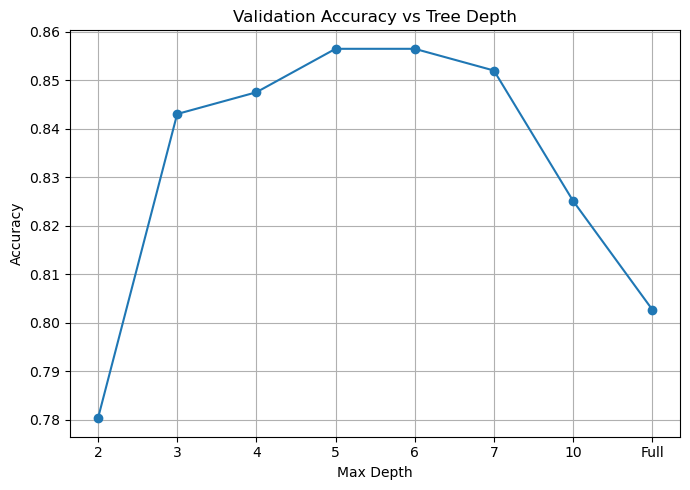

In [14]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score

depths = [2, 3, 4, 5, 6, 7, 10, None]
results = []

for d in depths:
    model = DecisionTreeClassifier(max_depth=d, random_state=1)
    model.fit(train_X, train_y)
    preds = model.predict(val_X)

    acc = accuracy_score(val_y, preds)
    prec = precision_score(val_y, preds)
    rec = recall_score(val_y, preds)

    results.append({
        'Depth': d if d is not None else 'Full',
        'Accuracy': acc,
        'Precision': prec,
        'Recall': rec
    })

import matplotlib.pyplot as plt

depth_labels = [str(r['Depth']) for r in results]
accs = [r['Accuracy'] for r in results]

plt.figure(figsize=(7, 5))
plt.plot(depth_labels, accs, marker='o', linestyle='-')
plt.title("Validation Accuracy vs Tree Depth")
plt.xlabel("Max Depth")
plt.ylabel("Accuracy")
plt.grid(True)
plt.tight_layout()
plt.show()

### 6.1 Tree Depth Tuning – Classification Performance Analysis

We trained multiple `DecisionTreeClassifier` models on Titanic survival data with varying `max_depth` values. The goal was to observe how model complexity influences generalization performance.

#### Validation Accuracy by Tree Depth

| Max Depth | Accuracy |
|-----------|----------|
| 2         | 0.780    |
| 3         | 0.843    |
| 4         | 0.847    |
| 5         | 0.857    |
| 6         | 0.857    |
| 7         | 0.853    |
| 10        | 0.832    |
| Full      | 0.803    |

#### Observations

- **Accuracy improved rapidly** from depth 2 to 5, with the peak at **depths 5 and 6 (≈85.7%)**.
- Beyond depth 6, accuracy began to **decline**, indicating that **overfitting** began to outweigh the benefits of added complexity.
- The fully grown tree underperformed compared to smaller trees, validating that unrestricted trees tend to memorize the training set rather than generalize.
- Depths 5 and 6 offered the **best tradeoff between bias and variance**, capturing the structure in the data without overfitting noise.

#### Conclusion

Constraining tree depth is a simple yet effective form of **regularization** in decision trees. This experiment reinforces the importance of tuning model complexity to achieve optimal generalization. For this dataset, a depth of **5 or 6** is ideal.

## 6.2 Random Forest Classifier

In [16]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix
from sklearn.metrics import accuracy_score, precision_score, recall_score

# Decision Tree with best depth
dt_model = DecisionTreeClassifier(max_depth=5, random_state=1)
dt_model.fit(train_X, train_y)
dt_preds = dt_model.predict(val_X)

# Store metrics
dt_acc = accuracy_score(val_y, dt_preds)
dt_prec = precision_score(val_y, dt_preds)
dt_rec = recall_score(val_y, dt_preds)


# Train the Random Forest model
rf_model = RandomForestClassifier(random_state=1)
rf_model.fit(train_X, train_y)

# Predict and evaluate
rf_preds = rf_model.predict(val_X)
rf_acc = accuracy_score(val_y, rf_preds)
rf_prec = precision_score(val_y, rf_preds)
rf_rec = recall_score(val_y, rf_preds)
rf_cm = confusion_matrix(val_y, rf_preds)

print(f"Accuracy: {rf_acc:.3f}")
print(f"Precision: {rf_prec:.3f}")
print(f"Recall: {rf_rec:.3f}")
print("Confusion Matrix:\n", rf_cm)

print(f"Decision Tree (d=5) → Accuracy: {dt_acc:.3f}, Precision: {dt_prec:.3f}, Recall: {dt_rec:.3f}")
print(f"Random Forest       → Accuracy: {rf_acc:.3f}, Precision: {rf_prec:.3f}, Recall: {rf_rec:.3f}")

Accuracy: 0.825
Precision: 0.780
Recall: 0.753
Confusion Matrix:
 [[120  18]
 [ 21  64]]
Decision Tree (d=5) → Accuracy: 0.857, Precision: 0.884, Recall: 0.718
Random Forest       → Accuracy: 0.825, Precision: 0.780, Recall: 0.753
